<a href="https://colab.research.google.com/github/dalatorrem/Diplomado_Metodos_UCentral_2023/blob/main/Lectura_38_LDA_stud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

<p align="center">
  <img src="https://raw.githubusercontent.com/lacamposm/Diplomado_Metodos_UCentral/main/data/images/imagen_ucentral.jpg" alt="logo_Ucentral" width="400px" height="300px">
</p>

***LDA o Linear Discriminant Analysis es una técnica de clasificación***

En contraste con la regresión logística, LDA permite enfrentar problemas multiclase.

<br>

**Ideas**

* Métricas para cada una de las clases.
* Para el caso univariado media y desviación estándar.
* Para el caso multivariado los análogos.

**Supuestos**
* Normalidad para las entradas.
* Misma estructura de varianza ( si se modela es QDA Quadratic Discriminant Analysis)

**Estimadores**
$$\mu_k = 1/n_k * \sum(x)$$

$$\sigma^2 = 1 / (n-K) * \sum((x – \mu_k)^2)$$

**Estimación de la clase**

Para todo $X$,  $P(X=x|y=k)$ corresponde a la probabilidad de que X tome el valor observado, asumiendo que pertenece a la clase $k$, usando la regla de Bayes se obtiene la probabilidad $P(y=k|x)$ la clase $k$ que maximice la probabilidad corresponde a la predicción del algoritmo.  

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api  as smf
import warnings
##
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
##
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"

## ***Nuevo modelo de clasisificación para la predicción de los incumplimientos del pago en préstamos en Lending club.***

## ***Introducción.***



Vamos a usar nuestro modelo de la lectura anterior y será tomado como referencia para ser comparado con este nuevo clasificador.

In [2]:
## Cargamos el Dataset. Usamos el conocimiento del mismo para que sea importando con el tipo de dato
## adecuado en cada variables.
df = pd.read_csv(url_base + "Logistic_Regression_1.csv",
                 dtype = {"loan_status":"category", "annual_inc":"float",
                          "verification_status":"category", "emp_length":"category",
                          "home_ownership":"category", "int_rate":"object",
                          "loan_amnt":"float", "purpose":"category",
                          "term":"category", "grade":"category"})
df["int_rate"] = df["int_rate"].str.replace("%","").astype("float")
df.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000.0,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500.0,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400.0,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000.0,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000.0,other,60 months,B


In [3]:
## Ajustamos el modelo de regresión logística de la lectura anterior.
df_full = df.copy()
## Variable objetivo numérica
df_full["loan_status"]= df_full["loan_status"].cat.codes
## MODELO
formula1 = "loan_status ~ int_rate + annual_inc + loan_amnt+"
formula2 = "verification_status + emp_length + home_ownership + purpose + term+ grade"
lr_full = smf.logit(formula = formula1+formula2, data = df_full).fit()
## AUC
p_hat = lr_full.predict(df_full.drop(columns = ["loan_status"]))
fpr, tpr, thresholds = roc_curve(df_full["loan_status"],p_hat)
print("AUC={:.3f}".format(auc(fpr, tpr)))

Optimization terminated successfully.
         Current function value: 0.377925
         Iterations 7
AUC=0.691


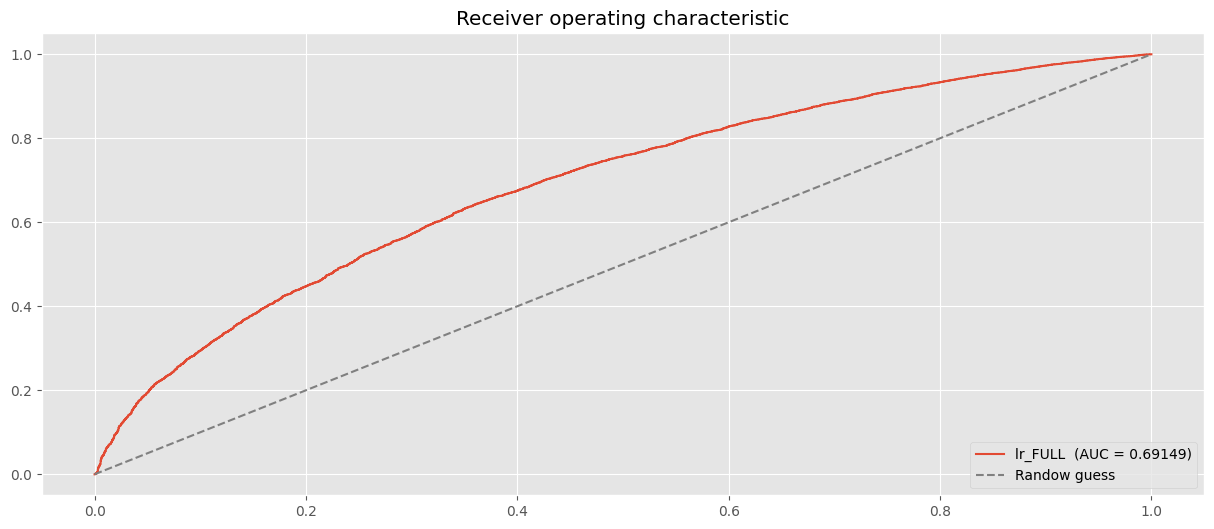

In [4]:
## Curva ROC modelo FULL.
fpr, tpr, thresholds = roc_curve(df_full["loan_status"],p_hat)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label = "lr_FULL  (AUC = {:.5f})".format(roc_auc),)
##
plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()

La regresión logística es uno de los algoritmos de clasificación más utilizados, pero por supuesto no es el único. Si la relación subyacente entre el logit de probabilidades y las covariables no es lineal, debemos considerar términos de orden superior de las covariables para que el modelo logístico sea válido. Hacerlo requiere mucho ajuste y experimentación. En tales casos, a menudo es mejor buscar un algoritmo de clasificación que no se base en una suposición específica sobre la relación entre la probabilidad del resultado y las covariables. Uno de esos modelos es el ***clasificador Naive Bayes***.

## ***El clasificador Naive Bayes.***

El clasificador que veremos a continuación se basa en un resultado estadístico muy simple pero poderoso llamado: ***Teorema de Bayes.*** Vamos entonces a recordar algunos conceptos para desglosar el razonamiento. La idea general de este clasificador es la siguiente:

***Dado un individuo con ciertas características, usaremos el teorema de Bayes y los datos observados para estimar la probabilidad de que pertenezca a una clase u otra. La mayor de estas dos probabilidades determinaría cómo clasificamos el individuo.***



#### ***Ejemplo 1.***

Vamos a usar nuestros datos para estimar:

1. $\text{P(moroso)}$
2. $\text{P(no moroso)}$.

In [5]:
probas = df["loan_status"].value_counts(normalize = True)
proba_no_moroso, proba_moroso  = probas[0], probas[1]
print("P(moroso)={:.3f}\nP(no moroso)={:.3f}".format(proba_moroso,proba_no_moroso))

P(moroso)=0.141
P(no moroso)=0.859


Además, vamos a usar la definición de probabilidad condicional y los datos para estimar las probabilidades:

$$
\text{P(ingresos verificados|moroso) y P(ingresos verificados|no-moroso)}
$$


In [6]:
## Verified y moroso (Charged Off)
temp = df[(df["loan_status"]=="Charged Off") & (df["verification_status"]=="Verified")]["loan_status"]
temp_moro = df[(df["loan_status"]=="Charged Off")]                                    ## Los morosos.
#####################################################################################################
## Verified y no-moroso (Fully Paid)
temp1 = df[(df["loan_status"]=="Fully Paid") & (df["verification_status"]=="Verified")]["loan_status"]
temp1_no_moro = df[(df["loan_status"]=="Fully Paid")]                               ## Los NO-morosos.
#####################################################################################################
print("P(ingresos verificados|moroso)={:.3f}".format(len(temp)/len(temp_moro)))
print("P(ingresos verificados|no-moroso)={:.3f}".format(len(temp1)/len(temp1_no_moro)))

P(ingresos verificados|moroso)=0.363
P(ingresos verificados|no-moroso)=0.313


Vamos a usar el ***Teorema de Bayes*** para comparar este par de cantidades:

$$\text{P(moroso|ingreso verificado)} \text{ y } \text{P(no-moroso|ingreso verificado)}$$


Como:

1. $\text{P(moroso|ingreso verificado)}=\frac{\text{P(ingreso verificado|moroso)P(moroso)}}{\text{P(ingreso verificado)}}$

2. $\text{P(no-moroso|ingreso verificado)}=\frac{\text{P(ingreso verificado|no-moroso)P(no-moroso)}}{\text{P(ingreso verificado)}}$

y observando además que los 2 denominadores de las expresiones anteriores son iguales, tenemos:



In [7]:
p1 = len(temp)/len(temp_moro)*proba_moroso
p2 = len(temp1)/len(temp1_no_moro)*proba_no_moroso
##
print("P(moroso|ingreso verificado) es proporcional a {:.3f}".format(p1))
print("P(no-moroso|ingreso verificado) es proporcional a {:.3f}".format(p2))

P(moroso|ingreso verificado) es proporcional a 0.051
P(no-moroso|ingreso verificado) es proporcional a 0.269


De lo anterior podemos pensar en lo siguiente:

***Si solo tenemos información sobre el estado de verificación de ingresos de nuestros clientes, probablemente daríamos préstamos a aquellos clientes cuyos ingresos han sido verificados.***

¿Qué sucede si el cliente es `Source Verified` o `Not Verified`?

#### ***Ejercicio 1.***

Encuentre las siguientes probabilidades:

1. $\text{P(moroso|Source Verified)}$
2. $\text{P(no-moroso|Source Verified)}$

¿Que puede comentar frente a comparar las 2 probabilidades anteriores?

Luego, encuentre:

3. $\text{P(moroso|Not Verified)}$
4. $\text{P(no-moroso|Not Verified)}$

Comente la comparación de las 2 probabilidades anteriores.


In [8]:
## Celda de código para probar.
temp1=df[(df["loan_status"]=="Charged Off")&(df["verification_status"]=="Source Verified")]["loan_status"]
temp1_moro=df[(df["loan_status"]=="Charged Off")]
p1 = len(temp)/len(temp1_moro)*proba_moroso
print("P(moroso|Source verified) es proporcional a {:.3f}".format(p1))
##
temp2=df[(df["loan_status"]=="Fully Paid")&(df["verification_status"]=="Source Verified")]["loan_status"]
temp2_no_moro = df[(df["loan_status"]=="Fully Paid")]
p2 = len(temp2)/len(temp2_no_moro)*proba_no_moroso
print("P(no-moroso|Source verified) es proporcional a {:.3f}".format(p2))

P(moroso|Source verified) es proporcional a 0.051
P(no-moroso|Source verified) es proporcional a 0.217


In [9]:
## Celda de código para probar.
temp1=df[(df["loan_status"]=="Charged Off")&(df["verification_status"]=="Not Verified")]["loan_status"]
temp1_moro=df[(df["loan_status"]=="Charged Off")]
p1 = len(temp1)/len(temp1_moro)*proba_moroso
print("P(moroso|Not Verified) es proporcional a {:.3f}".format(p1))
##
temp2=df[(df["loan_status"]=="Fully Paid")&(df["verification_status"]=="Not Verified")]["loan_status"]
temp2_no_moro = df[(df["loan_status"]=="Fully Paid")]
p2 = len(temp2)/len(temp2_no_moro)*proba_no_moroso
print("P(no-moroso|Not Verified) es proporcional a {:.3f}".format(p2))

P(moroso|Not Verified) es proporcional a 0.053
P(no-moroso|Not Verified) es proporcional a 0.373


***Las probabilidades condicionales de ser NO moroso son siempre mayores que las de ser moroso.***

### ***Introducción al algoritmo.***


Vamos a considerar que la variable $Y$ tiene $l$ etiquetas, y que $Y$ junto con $\mathbf X=(X_1,X_2,...X_p)$ es un conjunto de característica tomadas para $n$ individuos. Por el ***Teorema de Bayes*** la probabilidad que un indiviudo pertenezca a determinada clase $i$ de $Y$ dados los predictores $\mathbf X$ es:

$$P(Y=i|\mathbf X)=\frac{P(\mathbf X|Y=i)*P(Y=i)}{P(\mathbf X)}$$

Tenemos este hecho:

$$P(\mathbf X|Y=i)=P(X_1=x_1,X_2=x_2,...,X_p=x_p|Y=i)=$$

$$P(X_1=x_1|Y=i)P(X_2=x_2|Y=i,X_1=x_1)...P(X_p=x_p|Y=i,X_1=x_1,...X_{p-1}=x_{p-1})$$



El supuesto que se hace y por el cual es denominado "ingenuo" (Naive) es de la [_**Independencia condicional**_](https://es.wikipedia.org/wiki/Independencia_condicional). Con este supuesto se sigue que:

$$P(\mathbf X|Y=i)=P(X_1=x_1|Y=i)P(X_2=x_2|Y=i)\ ... \ P(X_p=x_p|Y=i)$$

Que usando la notación de productoría se ve como:

$$P(X_1=x_1,X_2=x_2,...,X_p=x_p|Y=i)=\prod_{j = 1}^p P(X_j=x_j|Y=i)$$

En total, hemos visto que:

$$P(Y=i|X_1=x_1, \ldots, X_p=x_p)=\frac{\prod_{j=1}^p P(X_j=x_j|Y=i)P(Y=i)}{P(X_1=x_1, \ldots, X_n=x_n)}$$

y como $P(X_1=x_1, \ldots, X_n=x_n)$ es constante, entonces el clasificador Naive Bayes tiene la regla de clasificación:

$$\hat{y}=\arg\max_{i\in\{1,...l\}}\left\{ P(Y=i)\prod_{j=1}^p P(X_j=x_j|Y=i)\right\}$$

***Nota:***

1. Cuando el número de covariables es grande, es difícil estimar probabilidades condicionales con solo proporciones. Pensemos en el caso que tenemos 10 covariables binarias, luego el número total de posibilidades que pueden tomar estas covariables es $2^{10}=1024$, luego necesitamos 1024 muestras al menos. Piense en 82 covariables cada una con 10 opciones... ¡Inmenso!

2. Recuerde que el clasificador ***Naive Bayes*** supone que *todas las covariables son independientes cuando están condicionadas por el resultado*. Esto posiblemente nunca sea cierto en el mundo real (***Naive***), pero aún así, muestra resultados poderosos.

### ***Modelo máximo a posteriori (MAP)***

Para este clasificador, y pensando en nuestro problema tenemos que un cliente con valores de covariables dados se clasifica como no moroso si:

$$
\text{P(no-moroso| covariables=valores)}>\text{P(moroso|covariables=valores)}
$$

Lo que equivale a:

$$
\begin{equation}
\text{P(covariables=valores| no-moroso)P(no-moroso)}>\text{P(covariables=valores| moroso)P(moroso)}
\end{equation}
$$

Las expresiones inmersas determinan lo siguiente:

1. $\text{P(moroso)}$ y $\text{P(no-moroso)}$. Este par de probabilidades se obtienen del Dataset.

2. $\text{P(covariables=valores)}$. Esta es la probabilidad de tener un cliente cuyas covariables sean iguales a $\text{valores}$. Esto también se puede estimar mediante proporciones, pero en realidad no es necesario estimar esta cantidad en absoluto.

3. $\text{P(covariables=valores | no-moroso)}$ y $\text{P(covariables=valores | moroso)}$. Podemos estimarlos observando la proporción de morosos y no morosos con covariables iguales a $\text{valores}$. Pero si tenemos muchas covariables, el número de tales morosos podría ser extremadamente pequeño o incluso igual a cero. El principal desafío en la construcción de un clasificador ***Naive Bayes*** es estimar estas probabilidades particulares.



#### ***Ejemplo 2.***


Vamos a encontrar un estimación ***Naive*** de:

1. $\text{P(term, verification_status|moroso)}$
2. $\text{P(term,verification_status|no-moroso)}$

Para todos los valores de las features categóricas `term` y `verification_status`.

***Solución:***

Debemos tener en mente que nuestra solución ***Naive*** hará uso de:

1. $\text{P(term, verification_status|moroso)}=\text{P(term|moroso)*P(verification_status|moroso)}$

2. $\text{P(term, verification_status|no-moroso)}=\text{P(term|no-moroso)*P(verification_status|no-moroso)}$

In [10]:
### Caso moroso
df_moro  = df[df["loan_status"]=="Charged Off"]
term_moro =df_moro["term"].value_counts()/df_moro.shape[0]
verifi_moro = df_moro["verification_status"].value_counts()/df_moro.shape[0]
###
print("Estimación DADO moroso")
moro = pd.DataFrame(verifi_moro.values.reshape(3,1).dot(term_moro.values.reshape(1,2)),
                    columns=term_moro.index,index=verifi_moro.index)
moro

Estimación DADO moroso


,36 months,60 months
Not Verified,0.212872,0.163966
Verified,0.205292,0.158127
Source Verified,0.146726,0.113017


In [11]:
### Caso NO-moroso
df_nmoro = df[df["loan_status"]=="Fully Paid"]
term_no_moro=df_nmoro["term"].value_counts()/df_nmoro.shape[0]
verifi_no_moro=df_nmoro["verification_status"].value_counts()/df_nmoro.shape[0]
###
print("Estimación DADO no-moroso")
no_moro = pd.DataFrame(verifi_no_moro.values.reshape(3,1).dot(term_no_moro.values.reshape(1,2)),
                       columns=term_no_moro.index,index=verifi_no_moro.index)
no_moro

Estimación DADO no-moroso


,36 months,60 months
Not Verified,0.329195,0.105166
Verified,0.237173,0.075768
Source Verified,0.191516,0.061182


#### ***Ejemplo 3.***

Piense que ha llegado un cliente que tiene los ingresos verificados y con un término de 60 meses, utilizar el clasificador Naive Bayes para tomar una decisión frente al préstamo.

In [12]:
## Moroso
moro*proba_moroso

,36 months,60 months
Not Verified,0.029919,0.023046
Verified,0.028854,0.022225
Source Verified,0.020622,0.015885


In [13]:
## No-Moroso
no_moro*proba_no_moroso

,36 months,60 months
Not Verified,0.282926,0.090385
Verified,0.203838,0.065119
Source Verified,0.164598,0.052583


Debemos clasificarlo como ***NO-MOROSO***, aunque deberia observar que es este modelo, TODOS se deben clasificar como NO-MOROSO. ¿Porqué?

### ***Situación covariables continuas.***

En la situación anterior tomamos el cálculo de las probabilidades para el caso en que las covariables sean discretas. La pregunta natural es: ¿qué pasa con las variables no categóricas?. En estos casos, necesitamos ajustar una *distribución* a los datos. Dado que en el mundo muchas cosas se rigen por una distribución normal, será esta quien vamos a utilizar.

Para ajustar una distribución normal, necesitamos solo su media y varianza. La distribución normal con media igual a la ***media muestral y varianza igual a la varianza muestral de la covariable*** resulta ser una muy buena aproximación. Una vez que obtengamos esta distribución normal, las probabilidades se pueden calcular directamente para cualquier valor de la covariable.

**Nota:** Se debe ajustar sus datos a una distribución que tenga sentido: hay muchas para elegir y su elección debe ser informada por el EDA que realiza antes del modelado.

#### ***Ejemplo 4.***

Encuentre la distribución normal que más se "alinee" con la distribución observada de `annual_inc` en morosos. Con base en esta distribución normal, calcule $\text{P(annual_inc=10,000|moroso)}$.

***Solución:***

De  `scipy.stats` vamos a usar `norm` y a su vez a `pdf()` para calcular la densidad de una distribución normal en un valor dado.

In [14]:
mean_est = df_moro["annual_inc"].mean()           ### Media
std_est  = df_moro["annual_inc"].std()            ### Desviación estándar
print(f"P(annual_inc=10,000|moroso) = {norm.pdf(10000, loc = mean_est, scale = std_est)}")

P(annual_inc=10,000|moroso) = 4.473123137400818e-06


---

Para el caso que tengamos más variables continuas, estimamos todas estas probabilidades condicionales de covariables individuales, las multiplicamos para obtener nuestra estimación final de $\text{P(covariables=valores|moroso)}$.

Pensando en general, para obtener:

$$\text{P(no-moroso|covariables=valores)}$$
$$\text{y}$$
$$\text{P(moroso|covariables=valores)}$$

Procedemos así:

1. Estime $\text{P(moroso)}$ y $\text{P(no-moroso)}$.
2. Estime $\text{P(covariables=valores|moroso)}$ y $\text{P(covariables=valores|no-moroso)}$
3. Estime $\text{P(no-moroso|covariables=valores)}$ con la siguiente ecuación:

$$
    \frac{\text{P(covariables=valores|no moroso)}\text{P(no moroso)}}{\text{P(covariables=valores|moroso)}\text{P(moroso)}+ \text{P(covariables=valores|no-moroso)}\text{P(no-moroso)}}
$$

4. Estime $\text{P(moroso|covariables=valores)}$ con la siguiente ecuación:

$$
    \frac{\text{P(covariables=valores|moroso)}\text{P(moroso)}}{\text{P(covariables=valores|moroso)}\text{P(moroso)}+ \text{P(covariables=valores|no-moroso)}\text{P(no-moroso)}}
$$

***Nota:*** Notemos que del paso 3 la probabilidad condicional de incumplimiento está determinada por los valores de las covariables a través de las probabilidades condicionales $\text{P(covariables=valores|moroso)}$ y $\text{P(covariables=valores|no-moroso)}$. La relación entre estas dos cantidades refleja cuán diferente es la distribución de las covariables en los morosos frente a los no-morosos. ***Naive Bayes*** está comparando la distribución de covariables en grupos de muestras con diferentes resultados. Esto nos proporciona una forma de preseleccionar las variables que deberían incluirse en el clasificador Naive Bayes.

Visualicemos las distribuciones de covariables en nuestro conjunto de datos, estratificados por `loan_status`, para tener una idea de cuáles deben incluirse.

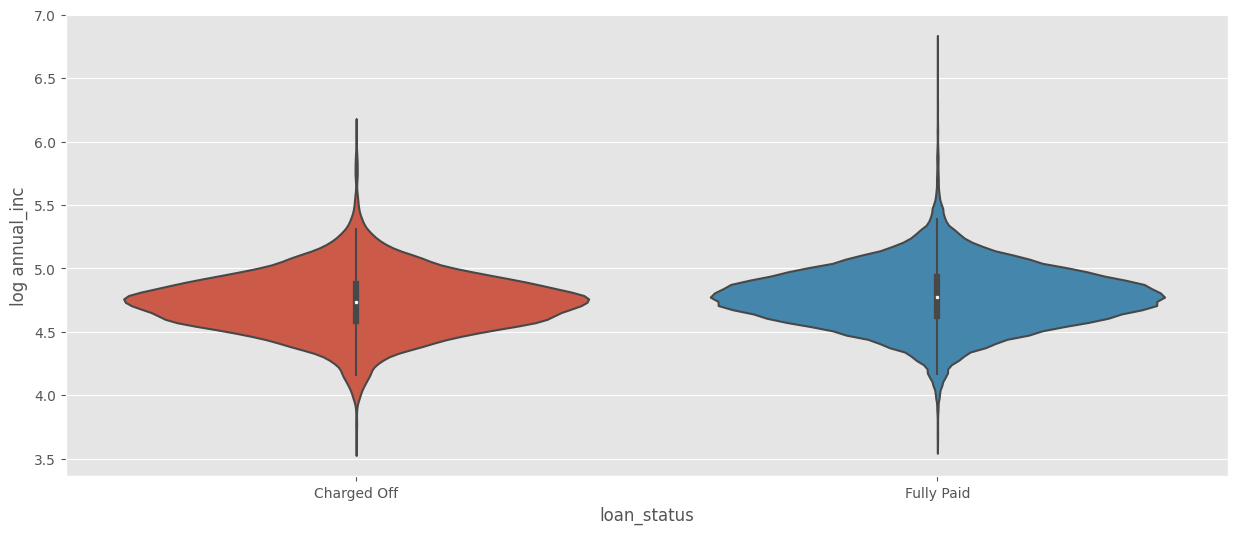

In [15]:
ax = sns.violinplot(x=df["loan_status"], y=np.log10(df["annual_inc"]));
ax.set(ylabel="log annual_inc");

Aunque la diferencia en los ingresos anuales no es muy grande, todavía podemos ver un ligero aumento en la media de los ingresos anuales en `Fully Paid` vs. `Charged Off`.

La distribución de `int_rate` es lo suficientemente cercana a la normal, pero la de `loan_amnt` parece un poco sesgada. Apliquemos una transformación de raíz cuadrada:

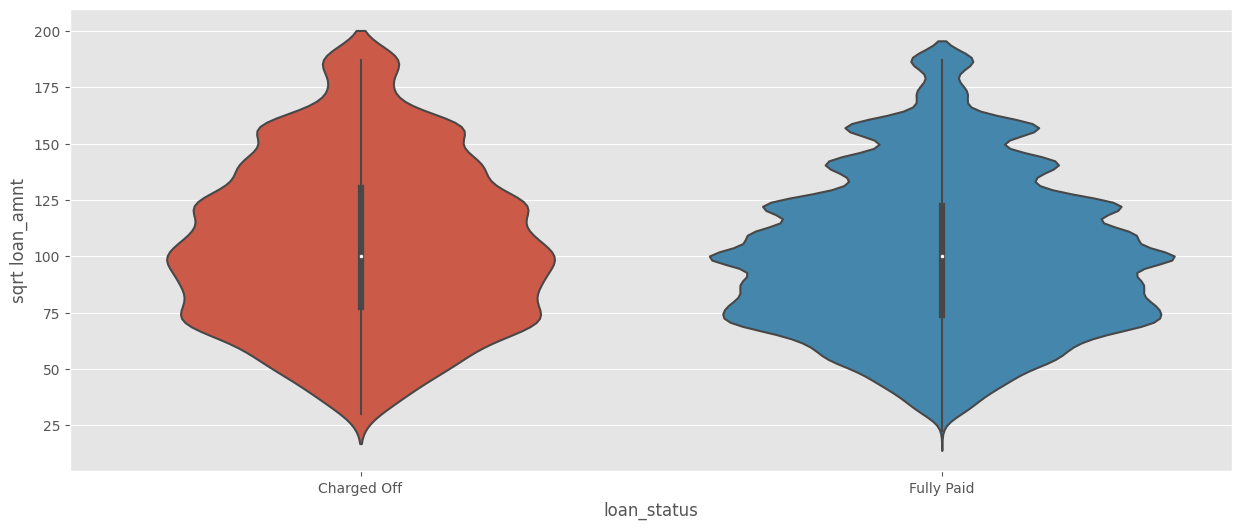

In [16]:
ax = sns.violinplot(x = df["loan_status"], y = np.sqrt(df["loan_amnt"]));
ax.set(ylabel="sqrt loan_amnt");

Del ejercicio anterior, encontramos que necesitamos transformar `annual_inc` y `loan_amnt` para que la suposición de normalidad pueda satisfacerse aproximadamente. Usaremos las variables transformadas para construir el estimador Naive Bayes:

In [17]:
df["annual_inc_log"] = np.log10(df["annual_inc"])
df["loan_amnt_sqrt"] = np.sqrt(df["loan_amnt"])

## ***Implementación del clasificador Naive Bayes***

Vamos a usar un par de clases de [`sklearn.naive_bayes`](https://scikit-learn.org/stable/modules/naive_bayes.html):

1. Para el caso de covariables categóricas:[`sklearn.naive_bayes.MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

2. Para el caso de covariables continuas: [`sklearn.naive_bayes.GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

Tengamos en cuenta que una implementación del clasificador ***Naive Bayes***  basado en covariables mixtas (continuas y categóricas) no está implementada en `sklearn` aún. Sin embargo, por las suposiciones de independencia ***Naive***, ṕarece natural usar las implementaciones para variables discretas (`sklearn.naive_bayes.MultinomialNB`) y continuas (`sklearn.naive_bayes.GaussianNB`) de la siguiente manera:

Supongamos por simplicidad que queremos estimar:

$$
\begin{align}
\text{P(no-moroso|loan_amnt, term)}
\end{align}
$$

Haciendo uso de:   

$$
\begin{equation}
\begin{aligned}
\text{P(no-moroso|loan_amnt)} \quad \text{y} \quad \text{P(no-moroso|term).}
\end{aligned}
\end{equation}
$$

Por el ***Teorema de Bayes*** tenemos:

$$
\begin{align}
\text{P(no-moroso|loan_amnt, term)}&=\frac{\text{P(term, loan_amnt|no-moroso)P(no-moroso)}}{\text{P(term, loan_amnt)}}, \\
&\approx \frac{\text{P(term|no-moroso)P(loan_amnt|no-moroso)P(no-moroso)}}{\text{P(term)P(loan_amnt)}},\\
&=\left[\frac{\text{P(term|no-moroso)}}{\text{P(term)}}\right]\left[\frac{\text{P(loan_amnt|no-moroso)}}{\text{P(loan_amnt)}}\right]\left[\frac{\text{P(no-moroso)P(no-moroso)}}{\text{P(no-moroso)}}\right], \\
&=\left[\frac{\text{P(term|no-moroso)P(no-moroso)}}{\text{P(term)}}\right]\left[\frac{\text{P(loan_amnt|no-moroso)P(no-moroso)}}{\text{P(loan_amnt)P(no-moroso)}}\right], \\
&=\frac{\text{P(no-moroso|term)}\text{P(no-moroso|loan_amnt)}}{\text{P(no-moroso)}}
\end{align}
$$

En palabras más simples, la suposición ***Naive*** de independencia nos permite calcular las probabilidades ajustando primero un modelo para las variables discretas y las variables continuas por separado. Luego multiplicamos estos valores y los dividimos por las probabilidades anteriores $\text{P(no moroso)}$ y $\text{P(moroso)}$.

In [18]:
## Implementación.
df_nb = df.copy()
label_encoder = LabelEncoder()
## Codificar las variables categóricas
for column in df_nb.select_dtypes("category"):
    df_nb[column] = label_encoder.fit_transform(df_nb[column])
y = df_nb["loan_status"]
## Ajustamos el modelo para variables continuas
gnb = GaussianNB()
Xcont = df_nb[["annual_inc_log","loan_amnt_sqrt","int_rate"]]
cont_probas = gnb.fit(Xcont, y).predict_proba(Xcont)          ## Probabilidades de cada registro.
## Ajustamos el modelo para variables categóricas
mnb = MultinomialNB()
Xcat = df_nb.select_dtypes("int").drop(columns=["loan_status"])
cat_probas = mnb.fit(Xcat, y).predict_proba(Xcat)             ## Probabilidades de cada registro.
## Probas de Naive-Bayes.
nb_probas = np.multiply(cont_probas, cat_probas)/np.array([proba_moroso, proba_no_moroso])
## Probas de la clase positiva.
df_nb["nb_predict_proba"] = nb_probas[:,1]
df_nb["nb_predict_proba"]

## Ajustamos el modelo para variables continuas
lda = LinearDiscriminantAnalysis()
df_nb["lda_predict_proba"] = lda.fit(Xcont, y).predict_proba(Xcont)[:,1]

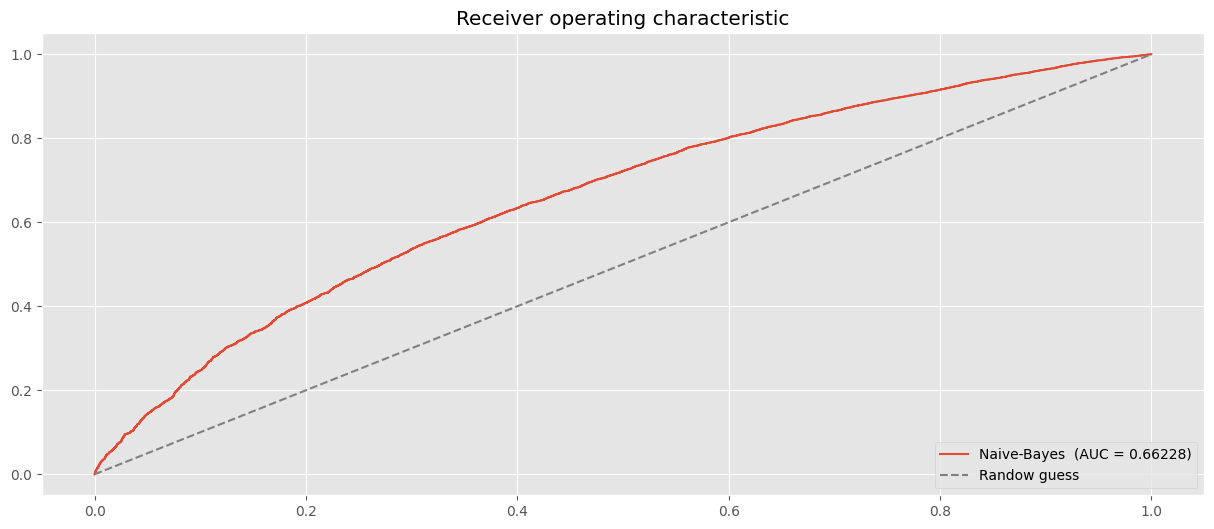

In [19]:
## Curva ROC modelo Naive Bayes.
fpr, tpr, thresholds = roc_curve(df_full["loan_status"],df_nb['nb_predict_proba'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label = "Naive-Bayes  (AUC = {:.5f})".format(roc_auc),)
##
plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()

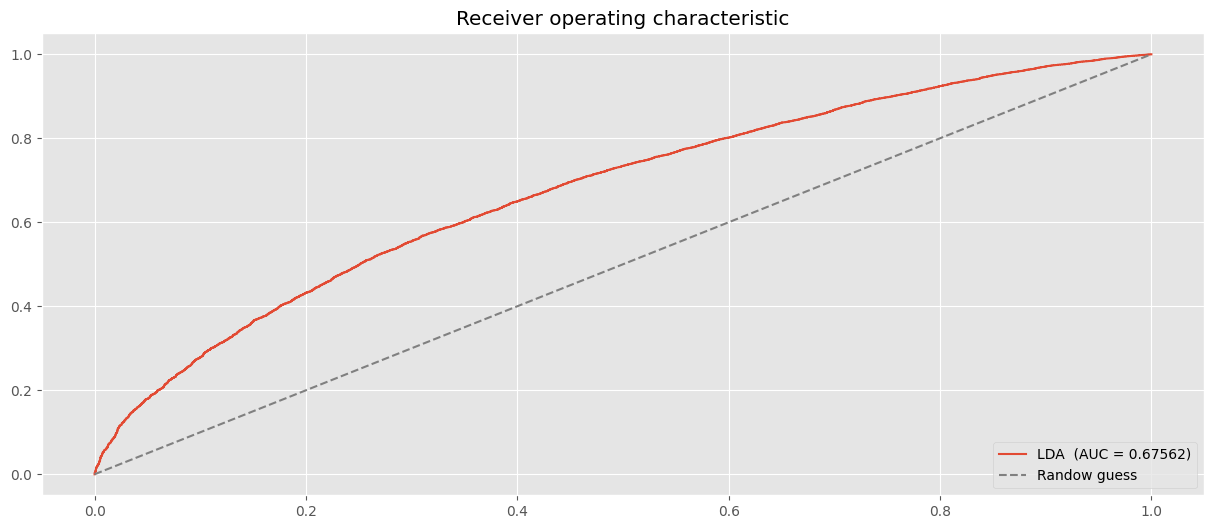

In [20]:
## Curva ROC modelo lda.
fpr, tpr, thresholds = roc_curve(df_full["loan_status"],df_nb['lda_predict_proba'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label = "LDA  (AUC = {:.5f})".format(roc_auc),)
##
plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()